In [12]:
import pandas as pd
import numpy as np
import os
import string
import re
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
scratch_path = os.environ['SCRATCH']
input_folder = "covid-map/twitter-dataset-processed-topic-2W"
output_folder = "covid-map/coherence-measures"

file_list = [x for x in os.listdir(os.path.join(scratch_path, input_folder)) if x.endswith("csv")]

input_path_list = [os.path.join(scratch_path, input_folder, x) for x in file_list]
output_path_list = [os.path.join(scratch_path, output_folder, x) for x in file_list]

In [6]:
def batch_process(input_path_list, output_path_list):
    for input_path, output_path in zip(input_path_list, output_path_list):
        df = pd.read_csv(input_path, lineterminator='\n')
        data = df['cleaned_text']
        return data
data = batch_process(input_path_list, output_path_list)

In [ ]:
%matplotlib inline

In [18]:
from time import time
from gensim.test.utils import common_corpus, common_dictionary, common_texts
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct

class LoadModel():
    
    def __init__(self, data_samples, n_components):
        self.data_samples = data_samples

        self.n_components = n_components
        self.n_top_words = 10 # equal to hidden layer of corex
        self.ifPrint = False

    def print_top_words(self, model, feature_names, n_top_words):
        # print("if print", self.ifPrint)
        topword_list = []
        for topic_idx, topic in enumerate(model.components_):
            message = "Topic #%d: " % topic_idx
            topwords = [feature_names[i]
                                 for i in topic.argsort()[:-self.n_top_words - 1:-1]]
            message += " ".join(topwords)
            topword_list.append(topwords)
            if self.ifPrint:
                print(message)
            
        return topword_list
        
    def runNMF_1(self):
        #print("runNMF_1")
        # Use tf-idf features for NMF.
        #print("Extracting tf-idf features for NMF...")
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                           stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(self.data_samples)
        
        # Fit the NMF model 1
        #print("Fitting the NMF model (Frobenius norm) with tf-idf features, 1")
        t0 = time()
        nmf = NMF(n_components=self.n_components, random_state=1,
                  beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
                  l1_ratio=.5).fit(tfidf)
        #print("done in %0.3fs." % (time() - t0))
        
        #print("\nTopics in NMF 1 model (generalized Kullback-Leibler divergence):")
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        
        topwords = self.print_top_words(nmf, tfidf_feature_names, self.n_top_words)
        return topwords
    
    def runNMF_2(self):
        #print("runNMF_2")
        # Use tf-idf features for NMF.
        #print("Extracting tf-idf features for NMF...")
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                           stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(self.data_samples)
        
        # Fit the NMF model 2
        #print("Fitting the NMF model (Frobenius norm) with tf-idf features, 2")
        t0 = time()
        nmf = NMF(n_components=self.n_components, random_state=1,
                  alpha=.1, l1_ratio=.5).fit(tfidf)
        #print("done in %0.3fs." % (time() - t0))
        
        #print("\nTopics in NMF 2 model (Frobenius norm):")
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        
        topwords = self.print_top_words(nmf, tfidf_feature_names, self.n_top_words)
        return topwords
        

    def runLDA(self):
        # print("runLDA")
        
        # Use tf (raw term count) features for LDA.
        #print("Extracting tf features for LDA...")
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                        stop_words='english')
        tf = tf_vectorizer.fit_transform(self.data_samples)
        
        #print("Fitting LDA models with tf features, ")
        lda = LatentDirichletAllocation(n_components=self.n_components, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0)
        t0 = time()
        lda.fit(tf)
        # print("done in %0.3fs." % (time() - t0))

        #print("\nTopics in LDA model:")
        tf_feature_names = tf_vectorizer.get_feature_names()
        topwords = self.print_top_words(lda, tf_feature_names, self.n_top_words)
        return topwords
    
    def runkMean(self):
        #print("runkMean")
        
        vectorizer = TfidfVectorizer(max_df=0.5,
                                     min_df=2, stop_words='english')
        
        X = vectorizer.fit_transform(self.data_samples)
        true_k = self.n_components
        
        km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                             init_size=1000, batch_size=1000, verbose=False)
        
        # print("Clustering sparse data with %s" % km)

        #print("\nTopics in kmean model:")
        t0 = time()
        km.fit(X)
        #print("done in %0.3fs" % (time() - t0))
        print()

        order_centroids = km.cluster_centers_.argsort()[:, ::-1]
        terms = vectorizer.get_feature_names()

        topword_list = []
        for i in range(true_k):
            topwords = []
            for ind in order_centroids[i, :10]:
                topwords.append(terms[ind])
            topword_list.append(topwords)
        return topword_list
    
    def runCorEx(self):
        #print("runCorEx")
        vectorizer = CountVectorizer(stop_words='english', binary=True)
        doc_word = vectorizer.fit_transform(self.data_samples)
        doc_word = ss.csr_matrix(doc_word)
        
        words = list(np.asarray(vectorizer.get_feature_names()))
        
        not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
        doc_word = doc_word[:,not_digit_inds]
        words    = [word for ind,word in enumerate(words) if not word.isdigit()]

        #print("corex document shape:",doc_word.shape)
        
        topic_model = ct.Corex(n_hidden=self.n_components, words=words, max_iter=200, verbose=False, seed=6)
        topic_model.fit(doc_word, words=words)
        
        topword_list = []
        # Print all topics from the CorEx topic model
        topics = topic_model.get_topics()
        for n,topic in enumerate(topics):
            topic_words, _ = zip(*topic)
            topword_list.append(topic_words)
            if self.ifPrint:
                print('{}: '.format(n) + ','.join(topic_words))
        return topword_list


In [27]:
def text_to_documents(data_sample):
    result = []
    for x in data_sample:
        s = x.strip()
        s = re.sub(r'[^\w\s]','',s)
        s = [x for x in s.split(" ") if len(x) != 0]
        if "ไวร" in s:
            continue
        result.append(s)
    return result

def get_coherence_measure(topics, documents):
    # print("getting coherence")
    dct = Dictionary(documents)
    
    u_mass = CoherenceModel(topics=topics, texts=documents, dictionary=dct, coherence='u_mass')
    uci = CoherenceModel(topics=topics, texts=documents, dictionary=dct, coherence='c_uci')
    npmi = CoherenceModel(topics=topics, texts=documents, dictionary=dct, coherence='c_npmi')
    c_v = CoherenceModel(topics=topics, texts=documents, dictionary=dct, coherence='c_v')
    
    result = {
        "u_mass": u_mass.get_coherence()/2.6,
        "uci": uci.get_coherence()/2.6,
        "npmi": npmi.get_coherence()/2.6,
        "c_v": c_v.get_coherence()
    }
    # print(result)
    
    return result



def plot_coherence(coherenceList, num_topics_list, title):
    print("average:", sum(coherenceList)/len(num_topics_list))

    plotData = pd.DataFrame({'Number of topics': num_topics_list,
                     'CoherenceScore': coherenceList})
    f,ax = plt.subplots(figsize=(10,6))
    sns.set_style("darkgrid")
    sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
    # plt.axhline(y=-3.9)
    plt.title(title)
    plt.show()


def coherence_lda(data_sample, documents, num_topics_list):
    print("run lda")
    coherenceList_umass = []
    coherenceList_uci = []
    coherenceList_npmi = []
    with tqdm(total=len(num_topics_list)) as pbar:
        for num_topics in num_topics_list:
            LM = LoadModel(data_sample, num_topics)
            topics = LM.runLDA()
            cm_result =  get_coherence_measure(topics[:10], documents)
            coherenceList_umass.append(cm_result['u_mass'])
            coherenceList_uci.append(cm_result['uci'])
            coherenceList_npmi.append(cm_result['npmi'])
            pbar.update(1)
    plot_coherence(coherenceList_umass, num_topics_list, "umass")  
    plot_coherence(coherenceList_uci, num_topics_list, "uci")   
    plot_coherence(coherenceList_npmi, num_topics_list, "npmi")   
    

def coherence_nmf_1(data_sample, documents, num_topics_list):
    print("run nmf 1")
    coherenceList_umass = []
    coherenceList_uci = []
    coherenceList_npmi = []
    with tqdm(total=len(num_topics_list)) as pbar:
        for num_topics in num_topics_list:
            LM = LoadModel(data_sample, num_topics)
            topics = LM.runNMF_1()
            cm_result =  get_coherence_measure(topics[:10], documents)
            coherenceList_umass.append(cm_result['u_mass'])
            coherenceList_uci.append(cm_result['uci'])
            coherenceList_npmi.append(cm_result['npmi'])
            pbar.update(1)
    plot_coherence(coherenceList_umass, num_topics_list, "umass")  
    plot_coherence(coherenceList_uci, num_topics_list, "uci")   
    plot_coherence(coherenceList_npmi, num_topics_list, "npmi")    
    
def coherence_nmf_2(data_sample, documents, num_topics_list):
    print("run nmf 2")
    coherenceList_umass = []
    coherenceList_uci = []
    coherenceList_npmi = []
    with tqdm(total=len(num_topics_list)) as pbar:
        for num_topics in num_topics_list:
            LM = LoadModel(data_sample, num_topics)
            topics = LM.runNMF_2()
            cm_result =  get_coherence_measure(topics[:10], documents)
            coherenceList_umass.append(cm_result['u_mass'])
            coherenceList_uci.append(cm_result['uci'])
            coherenceList_npmi.append(cm_result['npmi'])
            pbar.update(1)
    plot_coherence(coherenceList_umass, num_topics_list, "umass")  
    plot_coherence(coherenceList_uci, num_topics_list, "uci")   
    plot_coherence(coherenceList_npmi, num_topics_list, "npmi")    
    
def coherence_corex(data_sample, documents, num_topics_list):
    print("run corex")
    coherenceList_umass = []
    coherenceList_uci = []
    coherenceList_npmi = []
    with tqdm(total=len(num_topics_list)) as pbar:
        for num_topics in num_topics_list:
            LM = LoadModel(data_sample, num_topics)
            topics = LM.runCorEx()
            cm_result = get_coherence_measure(topics[:10], documents)
            coherenceList_umass.append(cm_result['u_mass'])
            coherenceList_uci.append(cm_result['uci'])
            coherenceList_npmi.append(cm_result['npmi'])
            pbar.update(1)
    plot_coherence(coherenceList_umass, num_topics_list, "umass")  
    plot_coherence(coherenceList_uci, num_topics_list, "uci")   
    plot_coherence(coherenceList_npmi, num_topics_list, "npmi")    
    
def process_all(data):

    data_sample = data[:1000]
    documents = text_to_documents(data_sample)
    num_topics_list = np.arange(10,30)
    
#     test_topics = [['human', 'computer', 'system', 'interface'],['graph', 'minors', 'trees', 'eps']]
#     test_result = get_coherence_measure(test_topics, common_texts)
#     topics = LM.runkMean()
#     kmean_result = get_coherence_measure(topics, documents)      
    coherence_lda(data_sample, documents, num_topics_list)
    coherence_nmf_1(data_sample, documents, num_topics_list)
    coherence_nmf_2(data_sample, documents, num_topics_list)
    coherence_corex(data_sample, documents, num_topics_list)
    


  0%|          | 0/20 [00:00<?, ?it/s]

run lda


100%|██████████| 20/20 [03:00<00:00,  9.04s/it]


average: -4.221574874355202


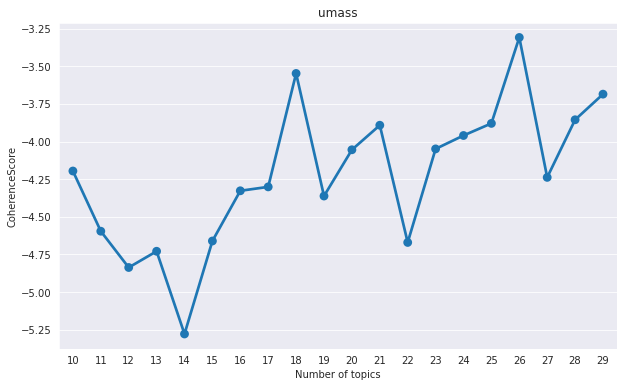

average: -2.6684391482723457


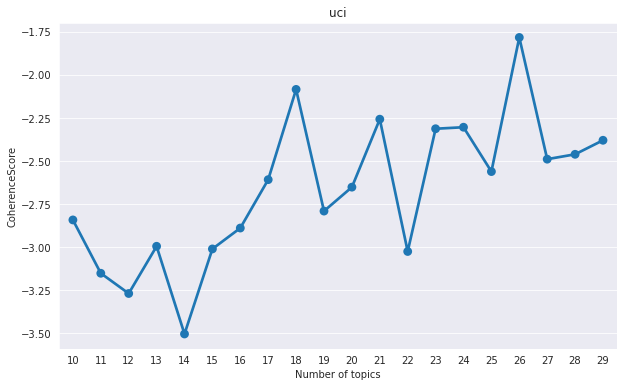

average: -0.04284360253465564


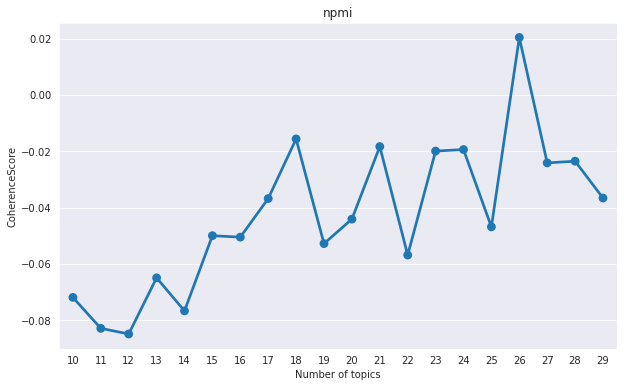

  0%|          | 0/20 [00:00<?, ?it/s]

run nmf 1


100%|██████████| 20/20 [02:49<00:00,  8.48s/it]


average: -3.9720423585516587


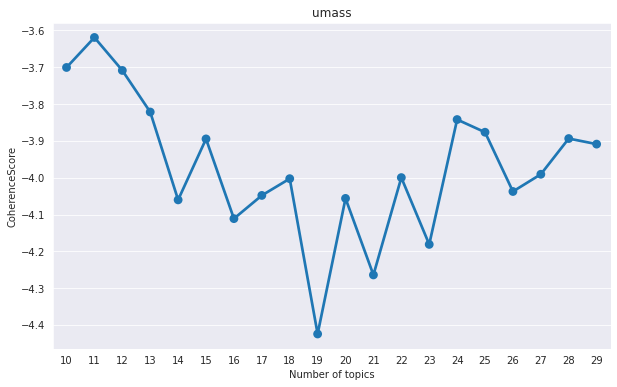

average: -2.5874290402982885


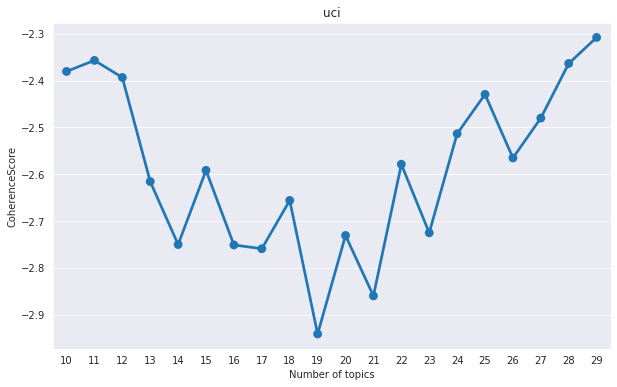

average: -0.05744358908352729


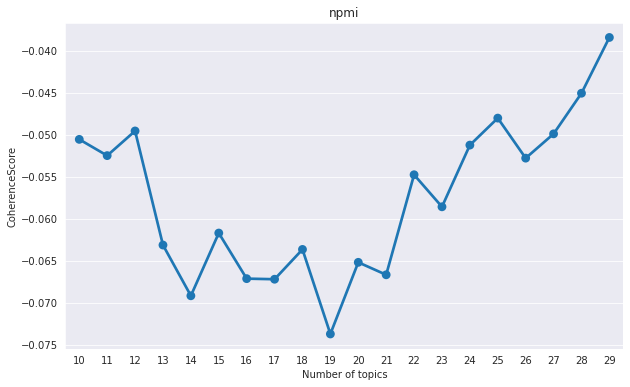

  0%|          | 0/20 [00:00<?, ?it/s]

run nmf 2


100%|██████████| 20/20 [02:42<00:00,  8.11s/it]


average: -4.034120291090874


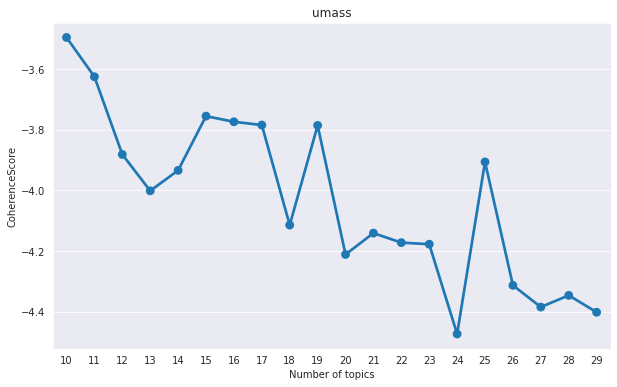

average: -2.3693812238688814


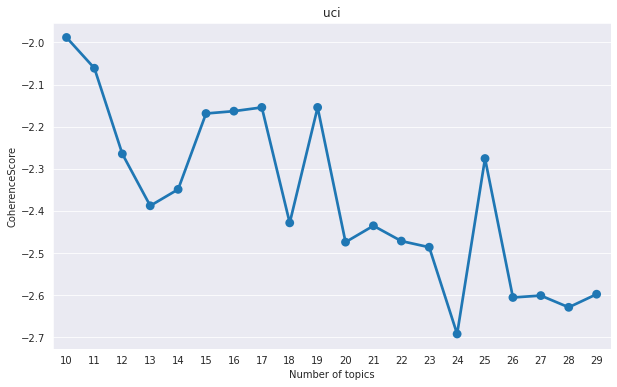

average: -0.031436722816768285


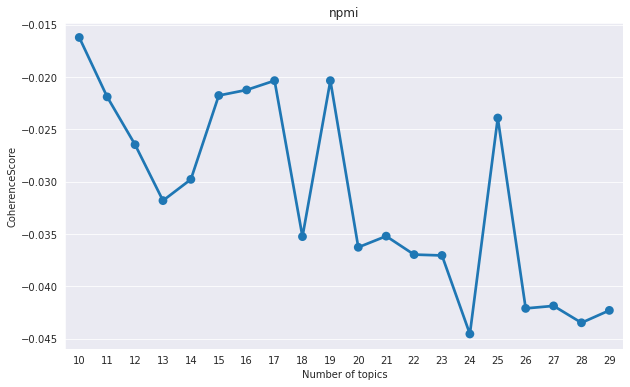

  0%|          | 0/20 [00:00<?, ?it/s]

run corex


100%|██████████| 20/20 [07:23<00:00, 22.18s/it]


average: -6.295094307218143


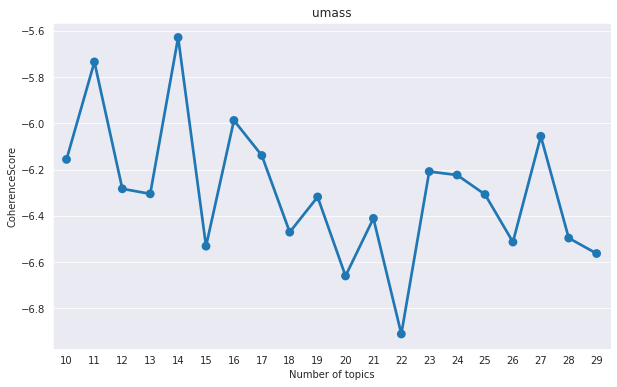

average: -4.6365543579574835


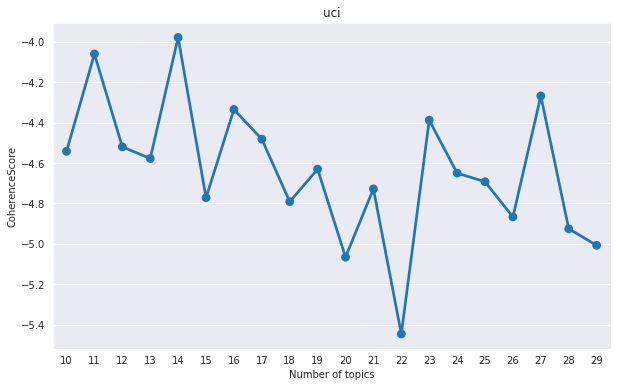

average: -0.13043244461394976


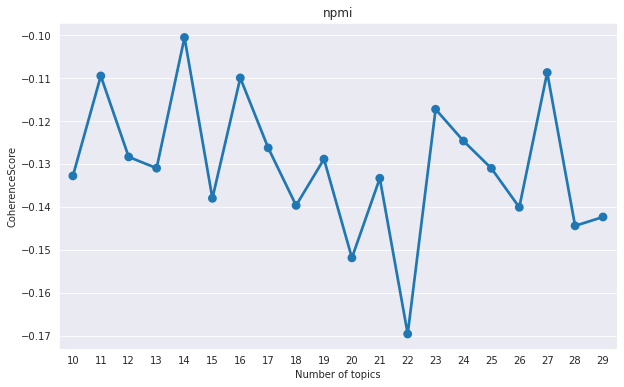

In [28]:
process_all(data)

In [32]:
-6.295094307218143*0.6

-3.777056584330886

In [33]:
-4.6365543579574835*0.6

-2.78193261477449

In [34]:
-0.13043244461394976*0.6

-0.07825946676836985